### Лабораторная работа №6: Градиентный бустинг 
##### Выполнил студент группы: 6131-010402D Павлов Владислав

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as pltx

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, mean_absolute_error, mean_squared_error, 
                             r2_score, classification_report)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, DMatrix
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from warnings import filterwarnings

import shap
filterwarnings("ignore")


### 1. Загрузка датасета

In [2]:
df = pd.read_csv("bank-full.csv")

### 2. Датасет и подготовка данных:
### 2.1 Привести описание датасета.

#### Датасет содержит данные о звоннках маркетинговой компании для банковского учреждения 
#### Цель - прогнозирование подписания продукта

| Признак               | Описание                                         | Единицы измерения | Тип данных |
|:----------------------|:-------------------------------------------------|:------------------|:-----------|
| Age               | Возраст клиента                                  | Годы              | Числовой   |
| Job                | Профессия клиента                                | -                 | Категориальный |
| Martial    | Семейное положение клиента                       | -                 | Категориальный |
| Education           | Уровень образования клиента                      | -                 | Категориальный |
| Default                | Имеет ли клиент задолженность по кредиту?        | -                 | Категориальный |
| Housing                 | Имеет ли клиент ипотечный кредит                 | -                 | Категориальный |
| Loan                  | Имеет ли клиент личный займ                      | -                 | Категориальный |
| Balance                | Индивидуальный баланс клиента                    | Дирхам            | Числовой   |
| Contact               | Тип коммуникации                                 | -                 | Категориальный |
| Month                 | Последний месяц контакта в году                 | -                 | Категориальный |
| Day                  | Последний день недели контакта                  | -                 | Категориальный |
| Duration     | Продолжительность последнего контакта, в секундах| Секунды           | Числовой   |
| Campaign              | Количество контактов в рамках данной кампании   | -                 | Числовой   |
| Pdays                 | Количество дней с момента последнего контакта в предыдущей кампании | Дни | Числовой   |
| Previos            | Количество контактов перед данной кампанией для данного клиента | - | Числовой   |
| Poutcome  | Результат предыдущей маркетинговой кампании     | -                 | Категориальный |
| Y                     | Подписал ли клиент срочный депозит               | -                 | Категориальный |


In [3]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### 2.2 Осуществить предобработку данных (избавиться от null, убрать некоторые признаки и т.п.) - "подчистить данные".

In [5]:
# проверка на NAN
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
droped_features = ["contact", "month"]
df_droped = df.drop(columns= droped_features, axis = 1)
df_droped.head() # набор данных без кодирования категориальных признаков

,age,job,marital,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,5,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,5,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,5,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,5,198,1,-1,0,unknown,no


In [8]:

df_dropped = df_droped.copy()

binary_features = ['job', 'marital', 'education', 'poutcome','default', 'housing', 'loan', "y"]
label_encode = LabelEncoder()
encoded_features = {}

for feature in binary_features:
    encoded_features[feature] = label_encode.fit_transform(df_dropped[feature])
    df_dropped[feature] = encoded_features[feature]

df_dropped.head() # с кодированием категориальных признаков 



,age,job,marital,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,5,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,5,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,5,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,5,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,5,198,1,-1,0,3,0


### 2.3 Нормализовать численные данные.

In [9]:
# для кодированных данных
x_enc = df_dropped.drop("y", axis = 1)
y_enc = df_dropped["y"]
x_cat = df_droped.drop(["y"], axis = 1)
y_cat = df_droped["y"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_enc)
x_scaled_df = pd.DataFrame(x_scaled, columns = x_enc.columns)

### 2.4 Разбить выборку на обучающую и тестовую

In [10]:
x_enc_train, x_enc_test, y_enc_train, y_enc_test = train_test_split(x_enc, y_enc, test_size= 0.3, random_state= 42)

x_cat_train = x_cat.loc[x_enc_train.index]
x_cat_test = x_cat.loc[x_enc_test.index]
y_cat_train = y_cat.loc[y_enc_train.index]
y_cat_test = y_cat.loc[y_enc_test.index]


### 3. Для каждого из классификаторов (AdaBoost, GradientBoostingClassifier, XGBoost, CatBoost):


### 3.1  С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.

#### AdaBoost: подбор гиперпараметров

In [11]:
adb = AdaBoostClassifier()

adb_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
}

adb_grid_search = GridSearchCV(adb, adb_grid, cv = 5, verbose= 2, n_jobs= -1)
adb_grid_search.fit(x_enc_train, y_enc_train)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [12]:
adb_grid_search.best_params_

{'learning_rate': 0.7100000000000001, 'n_estimators': 140}

#### GradientBoosting: подбор гиперпараметров

In [13]:
grad_boost = GradientBoostingClassifier()

grad_boost_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
}

grad_boost_grid_search = GridSearchCV(grad_boost, grad_boost_grid, cv = 5, verbose= 2, n_jobs= -1)
grad_boost_grid_search.fit(x_enc_train, y_enc_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [14]:
grad_boost_grid_search.best_params_

{'learning_rate': 0.11, 'max_depth': 5, 'n_estimators': 60}

#### XGBoost: подбор гиперпараметров

In [15]:
# Создание XGBClassifier
xgb = XGBClassifier()

xgb_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'alpha': [0, 0.1, 0.2, 0.3],  # параметр регуляризации L1
    'lambda': [0, 0.1, 0.2, 0.3]  # параметр регуляризации L2
}

# Создание объекта GridSearchCV
xgb_grid_search = GridSearchCV(xgb, xgb_grid, cv=5, verbose=2, n_jobs=-1)

# Обучение GridSearchCV на данных
xgb_grid_search.fit(x_enc_train, y_enc_train)


Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.2, 0.3],
                         'lambda': [0, 0.1, 0.2, 0.3],
                         'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [16]:
xgb_grid_search.best_params_

{'alpha': 0,
 'lambda': 0.2,
 'learning_rate': 0.11,
 'max_depth': 5,
 'n_estimators': 120}

#### CatBoost: подбор гиперпараметров

In [17]:
# Создание CatBoostClassifier
catboost = CatBoostClassifier()

# Определение сетки параметров для поиска
catboost_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'l2_leaf_reg': [0, 0.1, 0.2, 0.3]  # параметр регуляризации L2
}

# Создание объекта GridSearchCV
catboost_grid_search = GridSearchCV(catboost, catboost_grid, cv=5, verbose=2, n_jobs=-1)

# Обучение GridSearchCV на данных
catboost_grid_search.fit(x_enc_train, y_enc_train)



Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
0:	learn: 0.6197627	total: 155ms	remaining: 20s
1:	learn: 0.5628310	total: 160ms	remaining: 10.3s
2:	learn: 0.5154881	total: 166ms	remaining: 7.02s
3:	learn: 0.4760135	total: 171ms	remaining: 5.38s
4:	learn: 0.4427882	total: 176ms	remaining: 4.41s
5:	learn: 0.4167600	total: 181ms	remaining: 3.75s
6:	learn: 0.3924354	total: 186ms	remaining: 3.27s
7:	learn: 0.3720281	total: 192ms	remaining: 2.92s
8:	learn: 0.3544987	total: 197ms	remaining: 2.64s
9:	learn: 0.3393272	total: 202ms	remaining: 2.42s
10:	learn: 0.3259681	total: 207ms	remaining: 2.24s
11:	learn: 0.3151260	total: 212ms	remaining: 2.08s
12:	learn: 0.3046322	total: 217ms	remaining: 1.96s
13:	learn: 0.2961210	total: 222ms	remaining: 1.84s
14:	learn: 0.2886356	total: 227ms	remaining: 1.74s
15:	learn: 0.2818033	total: 232ms	remaining: 1.65s
16:	learn: 0.2759665	total: 237ms	remaining: 1.58s
17:	learn: 0.2703390	total: 242ms	remaining: 1.5s
18:	learn: 0.2659841	total: 24

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001C70009CDF0>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [0, 0.1, 0.2, 0.3],
                         'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [18]:
catboost_grid_search.best_params_

{'l2_leaf_reg': 0.2,
 'learning_rate': 0.11,
 'max_depth': 7,
 'n_estimators': 130}

In [13]:
ada_best = AdaBoostClassifier(learning_rate= 0.71, n_estimators= 140)
ada_best.fit(x_enc_train, y_enc_train)

grad_best = GradientBoostingClassifier(learning_rate= 0.11, max_depth= 5, n_estimators= 60)
grad_best.fit(x_enc_train, y_enc_train)

xgb_best = XGBClassifier(alpha = 0, reg_lambda = 0.2, learning_rate = 0.11, max_depth = 5, n_estimators = 120)
xgb_best.fit(x_enc_train, y_enc_train)

cat_boost_best = CatBoostClassifier(l2_leaf_reg=0.2, learning_rate= 0.11, max_depth= 7, n_estimators= 130)
cat_boost_best.fit(x_enc_train, y_enc_train)

0:	learn: 0.6197627	total: 135ms	remaining: 17.4s
1:	learn: 0.5628310	total: 140ms	remaining: 8.97s
2:	learn: 0.5154881	total: 145ms	remaining: 6.13s
3:	learn: 0.4760135	total: 150ms	remaining: 4.71s
4:	learn: 0.4427882	total: 154ms	remaining: 3.85s
5:	learn: 0.4167600	total: 159ms	remaining: 3.28s
6:	learn: 0.3924354	total: 164ms	remaining: 2.88s
7:	learn: 0.3720281	total: 168ms	remaining: 2.57s
8:	learn: 0.3544987	total: 173ms	remaining: 2.33s
9:	learn: 0.3393272	total: 178ms	remaining: 2.13s
10:	learn: 0.3259681	total: 182ms	remaining: 1.97s
11:	learn: 0.3151260	total: 187ms	remaining: 1.84s
12:	learn: 0.3046322	total: 192ms	remaining: 1.73s
13:	learn: 0.2961210	total: 196ms	remaining: 1.63s
14:	learn: 0.2886356	total: 201ms	remaining: 1.54s
15:	learn: 0.2818033	total: 206ms	remaining: 1.46s
16:	learn: 0.2759665	total: 210ms	remaining: 1.4s
17:	learn: 0.2703390	total: 215ms	remaining: 1.34s
18:	learn: 0.2659841	total: 219ms	remaining: 1.28s
19:	learn: 0.2617038	total: 224ms	remainin

### 3.2 Обучить модели XGBoost и CatBoost с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".

In [14]:
cat_cols = [var for var in x_cat_train.columns if x_cat_train[var].dtype == 'object']
x_cat_train_cb = x_cat_train.copy()
x_cat_test_cb = x_cat_test.copy()

for col in cat_cols:
    x_cat_train_cb[col] = pd.Categorical(x_cat_train_cb[col])
    x_cat_test_cb[col] = pd.Categorical(x_cat_test_cb[col])

train_data_cat_as_is = Pool(data=x_cat_train_cb, label=y_cat_train, cat_features=cat_cols)
test_data_cat_as_is = Pool(data=x_cat_test_cb, label=y_enc_test, cat_features=cat_cols)

xgb_best_cat = XGBClassifier(alpha = 0, reg_lambda = 0.2, learning_rate = 0.11, max_depth = 5, n_estimators = 120, enable_categorical = True)
xgb_best_cat.fit(x_cat_train_cb, y_enc_train)


catboost_best_cat = CatBoostClassifier(l2_leaf_reg=0.2, learning_rate= 0.11, max_depth= 7, n_estimators= 130)
catboost_best_cat.fit(train_data_cat_as_is)

0:	learn: 0.6222273	total: 47.6ms	remaining: 6.14s
1:	learn: 0.5651309	total: 69.6ms	remaining: 4.45s
2:	learn: 0.5182330	total: 91.5ms	remaining: 3.88s
3:	learn: 0.4786983	total: 118ms	remaining: 3.72s
4:	learn: 0.4459738	total: 144ms	remaining: 3.6s
5:	learn: 0.4188532	total: 165ms	remaining: 3.41s
6:	learn: 0.3956209	total: 187ms	remaining: 3.29s
7:	learn: 0.3758529	total: 209ms	remaining: 3.18s
8:	learn: 0.3591381	total: 233ms	remaining: 3.13s
9:	learn: 0.3447135	total: 255ms	remaining: 3.06s
10:	learn: 0.3315610	total: 279ms	remaining: 3.02s
11:	learn: 0.3205996	total: 302ms	remaining: 2.97s
12:	learn: 0.3107539	total: 326ms	remaining: 2.93s
13:	learn: 0.3010791	total: 350ms	remaining: 2.9s
14:	learn: 0.2921670	total: 374ms	remaining: 2.87s
15:	learn: 0.2856156	total: 387ms	remaining: 2.75s
16:	learn: 0.2793647	total: 410ms	remaining: 2.73s
17:	learn: 0.2736237	total: 434ms	remaining: 2.7s
18:	learn: 0.2679128	total: 457ms	remaining: 2.67s
19:	learn: 0.2639259	total: 479ms	remaini

### 3.3 Итого получить 6 обученных моделей.

In [15]:
print(f"AdaBoost: {ada_best} \n GradientBoost: {grad_best} \n XGBClass_encode: {xgb_best} \n CatBoost_encode: {cat_boost_best} \n XGBC_catt: {xgb_best_cat} \n CatBoost_catt: {catboost_best_cat}")

AdaBoost: AdaBoostClassifier(learning_rate=0.71, n_estimators=140) 
 GradientBoost: GradientBoostingClassifier(learning_rate=0.11, max_depth=5, n_estimators=60) 
 XGBClass_encode: XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, ...) 
 CatBoost_encode: <catboost.core.CatBoostClassifier object at 0x00000166E99

### 3.4 Вывести метрики на тестовом наборе (как минимум classification_report, другие по желанию).

In [16]:
def show_metrics(x_values, y_values, model):
    pred = model.predict(x_values)
    class_rep = classification_report(y_values, pred)
    print(class_rep)


In [17]:
print("AdaBoostClassifier")
ada_metrics = show_metrics(x_enc_test, y_enc_test, ada_best)
print("GradientBoostingClassifier")
grad_metrics = show_metrics(x_enc_test, y_enc_test, grad_best)
print("XGBClassifier with coded")
xgb_code_metrics = show_metrics(x_enc_test, y_enc_test, xgb_best)
print("CatBoostClassifier with coded")
cat_code_metrics = show_metrics(x_enc_test, y_enc_test, cat_boost_best)
print("XGBClassifier as is")
xgb_cat_metrics = show_metrics(x_cat_test_cb, y_enc_test, xgb_best_cat)
print("CatBoostClassifier as is")
cat_cat_metrics = show_metrics(x_cat_test_cb, y_cat_test, catboost_best_cat)


AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.62      0.33      0.43      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.65      0.69     13564
weighted avg       0.88      0.90      0.88     13564

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.62      0.39      0.48      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.68      0.71     13564
weighted avg       0.89      0.90      0.89     13564

XGBClassifier with coded
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.62      0.40      0.49      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.69      0.72     13564
wei

### 3.5 Сравнить модели, выбрать лучшую

### Лучших моделей оказалось несколько: Gradientboostingclassifier, Xgbclassifier with coded, Catboostclassifier with coded, Catboostclassifier as is

#### Возьму в качестве лучшей модели "CatBoostClassifier as is"

In [18]:
best_model = "XGBClassifier as is"

### 4. Важность признаков:

### 4.1  С использованием shap.TreeExplainer получить SHAP-значения для лучшей модели.

In [19]:
explainer = shap.TreeExplainer(xgb_best_cat)
shap_values = explainer.shap_values(x_cat_train_cb)

### 4.2 Построить график shap.plots.force для одного объекта выборки и для среза произвольного размера.

In [20]:
shap.initjs()
shap_fp = shap.plots.force(explainer.expected_value, shap_values[0,:], x_cat_train_cb.iloc[0,:])

from IPython.display import HTML
HTML(f"<div style='background-color: Lavender;'>{shap.getjs() + shap_fp.html()}</div>")

In [21]:
shap.initjs()
shap_fp = shap.plots.force(explainer.expected_value, shap_values[0:100,:], x_cat_train_cb.iloc[0:100,:])

from IPython.display import HTML
HTML(f"<div style='background-color: Lavender;'>{shap.getjs() + shap_fp.html()}</div>")

### 4.3 Построить график shap.plots.bar для одного объекта выборки.

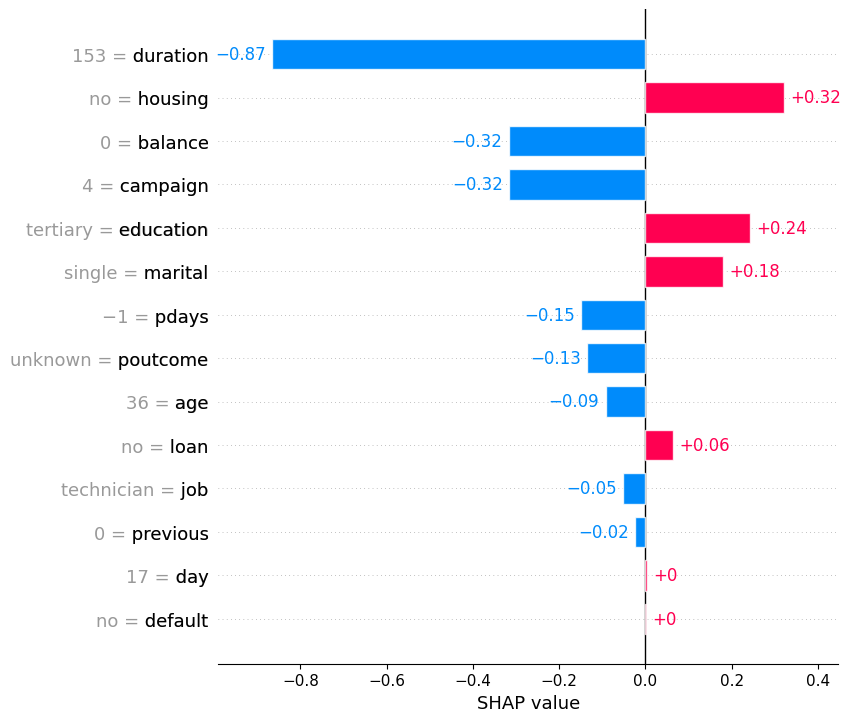

In [22]:
df_shap_values = explainer(x_cat_train_cb)
shap_bp = shap.plots.bar(df_shap_values[0], max_display=x_cat_train_cb.shape[1])

### 4.4 Построить график shap.plots.waterfall для одного объекта выборки.

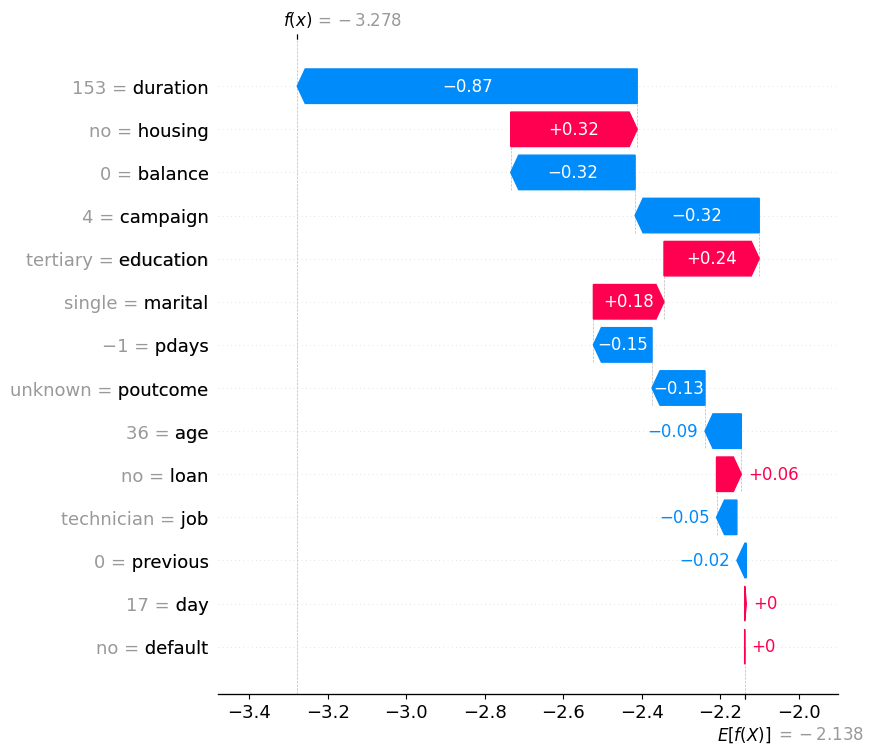

In [23]:
shap.plots.waterfall(df_shap_values[0], max_display=x_cat_train_cb.shape[1])

### 4.5 Построить 2 графика shap.plots.scatter для какого-нибудь признака. На одном раскрасить относительно себя, на втором – относительно другого признака.

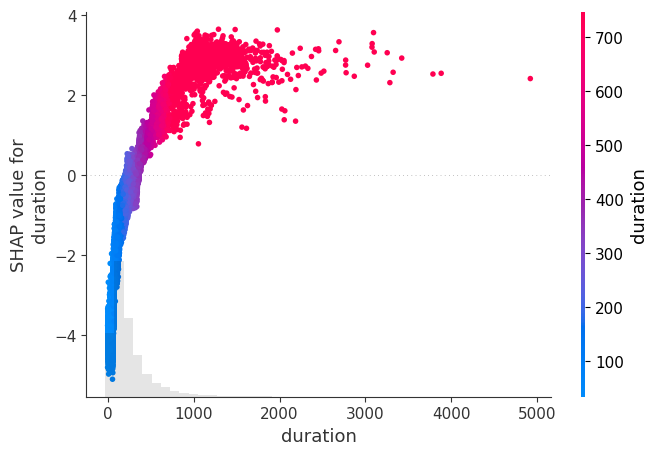

In [24]:
shap.plots.scatter(df_shap_values[:, "duration"], color=df_shap_values[:, "duration"])

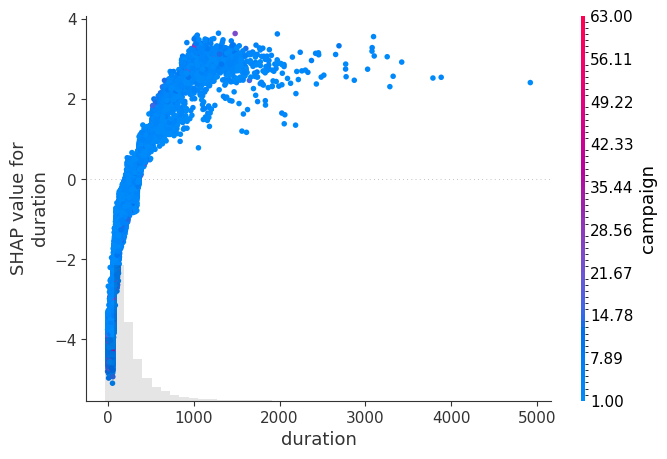

In [25]:
shap.plots.scatter(df_shap_values[:, "duration"], color=df_shap_values[:, "campaign"])

### 4.6 Построить график shap.plots.beeswarm для всех признаков.


<Axes: xlabel='SHAP value (impact on model output)'>

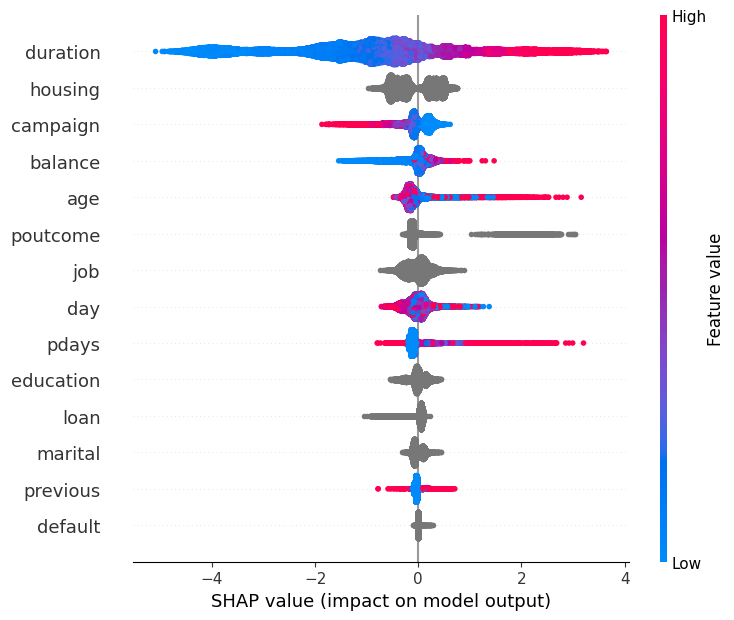

In [26]:
shap.plots.beeswarm(df_shap_values, max_display=x_cat_train_cb.shape[1], show=False)

### 4.7 Построить график shap.plots.bar для всех признаков.

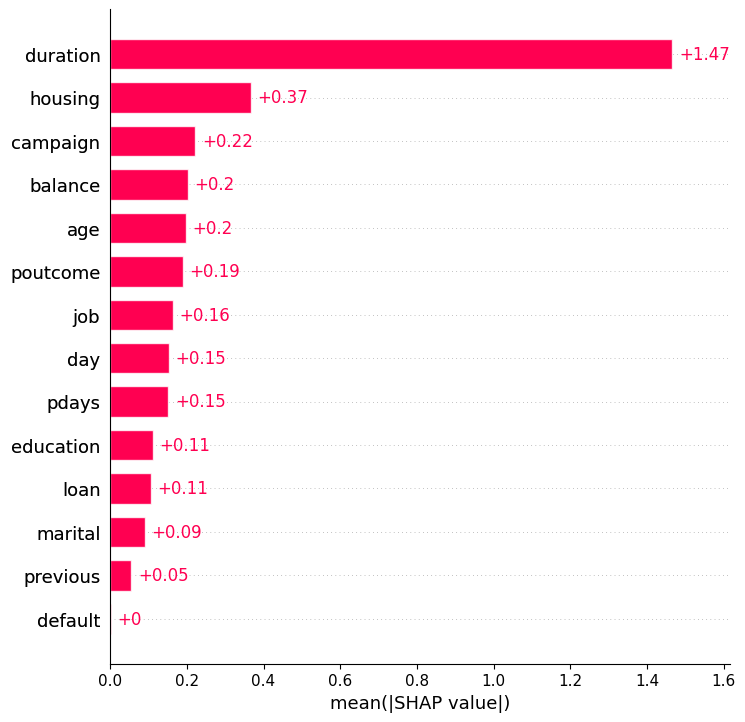

In [27]:
shap_bp = shap.plots.bar(df_shap_values, max_display=x_cat_train_cb.shape[1])

#### Оставим признаки, среднее значение SHAP больше 0.15

### 4.8 На основании двух последних графиков и/или используя feature_importance отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.

In [28]:
filterred_cols = ['job','poutcome','age','balance','campaign', 'housing', "duration"]

In [29]:
xgb_best_cat.fit(x_cat_train_cb[filterred_cols], y_enc_train) 

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, ...)

### 4.9 Сравнить метрики до и после фильтрации.

In [30]:
y_predict = xgb_best_cat.predict(x_cat_test_cb[filterred_cols])

print(classification_report(y_enc_test, y_predict))


              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.60      0.38      0.47      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.67      0.71     13564
weighted avg       0.88      0.90      0.89     13564



### 4.10 Визуализировать полученное дерево решений.

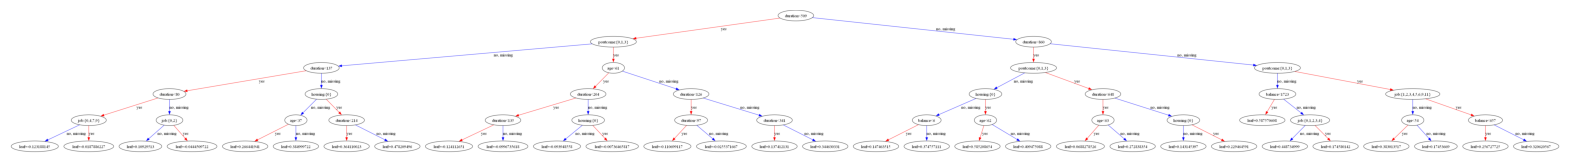

In [31]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Визуализация дерева решений
plt.figure(figsize=(20, 10))
plot_tree(xgb_best_cat, num_trees=0, ax=plt.gca())
plt.show()


### 5. Регрессия

### 5.1 С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели линейной регрессии с использованием XGBoost или CatBoost

In [32]:
target_train = x_enc_train["housing"]
x_train_regr = pd.concat([x_enc_train.drop(["housing"], axis=1), y_enc_train], axis=1)
x_train_regr["job"] = pd.Categorical(x_train_regr["job"])

target_test = x_enc_test["housing"]
x_test_regr = pd.concat([x_enc_test.drop(["housing"], axis=1), y_enc_test], axis=1)
x_test_regr["job"] = pd.Categorical(x_test_regr["job"])

In [33]:
print(x_train_regr)

       age job  marital  education  default  balance  loan  day  duration  \
10747   36   9        2          2        0        0     0   17       153   
26054   56   2        1          1        0      196     0   19       312   
9125    46   1        1          1        0        0     0    5        83   
41659   41   4        0          2        0     3426     0    1       302   
4443    38   1        1          1        0        0     0   20        90   
...    ...  ..      ...        ...      ...      ...   ...  ...       ...   
11284   44   3        2          0        0     1059     0   18      2093   
44732   23   8        2          2        0      508     0    8       210   
38158   34   9        0          2        0     1317     0   15       239   
860     33   5        1          1        0      165     0    7       111   
15795   38   1        1          0        0      -41     0   21        68   

       campaign  pdays  previous  poutcome  y  
10747         4     -1     

In [34]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Создание объекта регрессора XGBoost
xgb_model = XGBRegressor(enable_categorical=True)

# Определение параметров модели XGBoost
xgb_param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300]
}

# Поиск оптимальных параметров с помощью кросс-валидации
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5)
xgb_grid_search.fit(x_train_regr, target_train)



GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...e,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]})

In [35]:
xgb_grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [38]:
best_reg = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 200, enable_categorical = True)

In [39]:
best_reg.fit(x_train_regr, target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [41]:
y_reg_pred = best_reg.predict(x_test_regr)

### 5.2 Вывести метрики MSE, MAE, R2 на тестовом наборе

In [42]:
mse_reg = mean_squared_error(target_test, y_reg_pred)
mae_reg = mean_absolute_error(target_test, y_reg_pred)
r2_reg = r2_score(target_test, y_reg_pred)

print(f"Средняя квадратичная ошибка (MSE): {(mse_reg):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {(mae_reg):.3f}")
print(f"Коэффициент детерминации (R2 score): {(r2_reg):.3f}")

Средняя квадратичная ошибка (MSE): 0.194
Средняя абсолютная ошибка (MAE): 0.391
Коэффициент детерминации (R2 score): 0.215


### 5.3 Переобучить модель на отфильтрованном наборе признаков из пункта 4.

In [48]:
filterred_cols = ['job','poutcome','age','balance','campaign',"duration"]

best_reg.fit(x_train_regr[filterred_cols], target_train)
y_pred_filt = best_reg.predict(x_test_regr[filterred_cols])

### 5.4 Сравнить метрики до и после фильтрации.

In [51]:
mse_reg_filt = mean_squared_error(target_test, y_pred_filt)
mae_reg_filt = mean_absolute_error(target_test, y_pred_filt)
r2_reg_filt = r2_score(target_test, y_pred_filt)


print(f"Средняя квадратичная ошибка (MSE): {(mse_reg):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {(mae_reg):.3f}")
print(f"Коэффициент детерминации (R2 score): {(r2_reg):.3f}")

print(f"Средняя квадратичная ошибка после фильтрации (MSE): {(mse_reg_filt):.3f}")
print(f"Средняя абсолютная ошибка после фильтрации (MAE): {(mae_reg_filt):.3f}")
print(f"Коэффициент детерминации после фильтрации (R2 score): {(r2_reg_filt):.3f}")

Средняя квадратичная ошибка (MSE): 0.194
Средняя абсолютная ошибка (MAE): 0.391
Коэффициент детерминации (R2 score): 0.215
Средняя квадратичная ошибка после фильтрации (MSE): 0.213
Средняя абсолютная ошибка после фильтрации (MAE): 0.421
Коэффициент детерминации после фильтрации (R2 score): 0.139


### Метрики стали хуже